## Siamese Neural Networks 
### for Supervised Clustering of High Dimensional Spaces

In [1]:
!python -V
!which python

Python 3.8.5
/Users/seanmacrae/mobius/.venv/bin/python


In [2]:
# !echo {a}

In [3]:
sql_template = """
WITH
        investors AS (
        SELECT
            ID AS investorId,
            Level AS investorLevel,
            accredited_income AS accreditedIncome,
            accredited_net_worth AS accreditedNetWorth,
            accredited_entity AS accreditedEntity,
            accredited_license AS accreditedLicense,
            CASE WHEN status = "NULL" THEN NULL ELSE status END AS status
        FROM
        `portal_sync.account_753_dataset_0_file_1141349_Windfall_Data_2021_04_19_csv`
        ),

        investments AS (
        SELECT
            Investor_ID AS investorId,
            SUM(COALESCE(CAST(Amount AS float64), 0)) AS sumAmount,
            MIN(PARSE_TIMESTAMP("%m/%d/%y %H:%M", Investment_Date)) AS minInvestmentDate,
            MAX(PARSE_TIMESTAMP("%m/%d/%y %H:%M", Investment_Date)) AS maxInvestmentDate,
            COUNT(DISTINCT(PARSE_TIMESTAMP("%m/%d/%y %H:%M", Investment_Date))) AS countInvestmentDate,
            SUM(CAST(Closed AS int64)) AS closed
        FROM
        `portal_sync.account_753_dataset_0_file_1140988_Investments_by_Investor_2021_04_19_csv`
        GROUP BY 1
        ),

        leads AS (
        SELECT DISTINCT
          id AS investorId,
          PARSE_TIMESTAMP("%Y-%m-%d %H:%M:%S", l.created_at) AS createdAt,
        FROM
        `portal_sync.account_753_dataset_0_file_1251551_mv_windfall_data_2021_05_12_csv` l
        LEFT JOIN portal.match m ON l.id = m.candidate_id
        ),

        matches AS (
        SELECT DISTINCT
            account_id,
            windfall_id ,
            candidate_id,
            confidence
        FROM `portal.match`
        WHERE account_id = 753 AND confidence > 0.5
        ),

      training_data AS (
      SELECT
      CASE 
        WHEN (j.sumAmount >= 10000.0) THEN "ideal"
        WHEN (a.logNetWorth < 6.0 AND (j.sumAmount = 0.0 OR j.sumAmount IS NULL) AND l.createdAt < PARSE_TIMESTAMP("%Y-%m-%d", "2020-11-01")) THEN "non-ideal"
        ELSE "other" END AS label,
      * EXCEPT(investorId, account_id),
      FROM leads l
      LEFT JOIN investors i ON l.investorId = i.investorId
      LEFT JOIN investments j ON l.investorId = j.investorId
      LEFT JOIN matches m ON l.investorId = m.candidate_id
      LEFT JOIN `tranquil-garage-139216.people.audience_latest` a ON a.id = m.windfall_id
      WHERE m.candidate_id IS NOT NULL)
      
--       SELECT label, COUNT(label) FROM training_data GROUP BY 1
    SELECT * FROM training_data
    WHERE label != "other"
"""

In [4]:
# !pip install loaderbot
# !pip install grpcio

In [26]:
import loaderbot.big_query as bq
from google.cloud import bigquery, storage

bigquery_client = bigquery.Client(project="tranquil-garage-139216")
storage_client = storage.Client(project="tranquil-garage-139216")

# query training data
df = bq.query_table_and_cache(
    sql=sql_template,
    bigquery_client=bigquery_client,
    storage_client=storage_client
)

/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information 

In [27]:
import pandas as pd

print(df.shape)
df.head()

(12095, 131)


,label,createdAt,investorLevel,accreditedIncome,accreditedNetWorth,accreditedEntity,accreditedLicense,status,sumAmount,minInvestmentDate,...,lux_travel,num_vehicles,num_luxury_vehicles,num_ultra_luxury_vehicles,num_cars,num_trucks,num_suvs,num_vans,metroRank,stateRank
0,non-ideal,2019-09-19 17:18:03+00:00,Accredited,1,0,0,0,Pending Approval,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.740138,0.784328
1,non-ideal,2017-12-20 06:15:38+00:00,Sophisticated,0,0,0,0,Pending Approval,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.860757,0.887302
2,non-ideal,2016-11-17 13:57:53+00:00,Sophisticated,1,0,0,0,Pending Approval,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027779,0.176424
3,non-ideal,2013-09-16 10:51:47+00:00,Sophisticated,0,0,0,0,Active,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.386455,0.343682
4,ideal,2017-07-05 12:58:46+00:00,Sophisticated,0,0,0,0,Pending Approval,20000.0,2017-08-14 20:11:00+00:00,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.737037,0.782864


In [28]:
# df["status"].value_counts()

In [29]:
# positive_labels = ["Active", "Inactive"]
# df["label"] = [int(x in positive_labels) for x in df["status"]]

In [30]:
df["label"] = df["label"]
df["label"].value_counts() / len(df)

non-ideal    0.730054
ideal        0.269946
Name: label, dtype: float64

In [31]:
# df["label"] = df["label"].astype(bool).astype(int)

In [32]:
df["label"] = df["label"].replace({"ideal": 1, "non-ideal": 0}).astype(int)
df["label"]

0        0
1        0
2        0
3        0
4        1
        ..
12090    0
12091    0
12092    0
12093    0
12094    1
Name: label, Length: 12095, dtype: int64

In [33]:
# # sample df stratified by label
# df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(2_000))

## Tabular Learner

Before we train the Tabular Siamese Learner we will train baseline Tabular Learner for species classification... (why do we do this, exactly? can we just instantiate a Tabular Siamese Learner without a baseline Tabular Learner ???)

Ah yes, to init a new `TabularSiameseModel` we need to provide an `encoder` and `head` and the Tabular Learner will act as the `encoder` we init the `TabularSiameseModel` with.

In [34]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df,
    test_size=0.10,
    stratify=df["label"])

df_train.shape, df_test.shape
df = df_train.copy()

# shuffle data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [35]:
from fastai.tabular.all import CategoryBlock
                                
y_names = ["label"]
y_block = CategoryBlock()

exclude_vars = ["id", 
                "windfall_id", 
                "candidate_id", 
                "label", 
                'status', 
                'minInvestmentDate', 
                'maxInvestmentDate',
                'sumAmount',
                'countInvestmentDate',
                'closed',
                'confidence',
                'createdAt']

In [36]:
from mobius.utils import emb_sz_rule

cat_names = [x for x in df.select_dtypes(exclude=['int', 'float']).columns if x != y_names]
cat_names = [x for x in cat_names if x not in exclude_vars]

# calc embedding sizes for each categorical feature
emb_szs = {k: emb_sz_rule(len(df[k].unique())) for k in cat_names}
emb_szs

{'investorLevel': 3}

In [37]:
import numpy as np

cont_names = [x for x in df.select_dtypes([np.number]).columns if x != y_names]
cont_names = [x for x in cont_names if x not in exclude_vars]
cont_names

['accreditedIncome',
 'accreditedNetWorth',
 'accreditedEntity',
 'accreditedLicense',
 'logNetWorth',
 'logAccreditedNetWorth',
 'recentPurchaseDate',
 'recentDivorceDate',
 'recentDeathDate',
 'isBoatOwner',
 'isPlaneOwner',
 'recentPhilanthropicGiftDate',
 'recentFoundationAssociationDate',
 'isFoundationOfficer',
 'recentFoundationTrusteeDate',
 'hasFoundationAssociation',
 'hasCharityBoardMember',
 'hasCharityOfficer',
 'isMultiPropertyOwner',
 'isRentalPropertyOwner',
 'isHouseholdDebt',
 'logTotalHouseholdDebt',
 'recentSecTransactionAcquired',
 'recentSecTransactionDisposed',
 'recentPoliticalContributionDate',
 'isSmallBusinessOwner',
 'isCharityBoardMember',
 'isCharityOfficer',
 'primaryPropertyLoanToValue',
 'logPrimaryPropertyAvm',
 'hasTrust',
 'politicalDemocrat',
 'politicalRepublican',
 'politicalIndependent',
 'femaleCount',
 'maleCount',
 'minHouseholdAge',
 'avgHouseholdAge',
 'maxHouseholdAge',
 'metroNameRank',
 'propertyCount',
 'isSFROwner',
 'isCondoOwner',
 'i

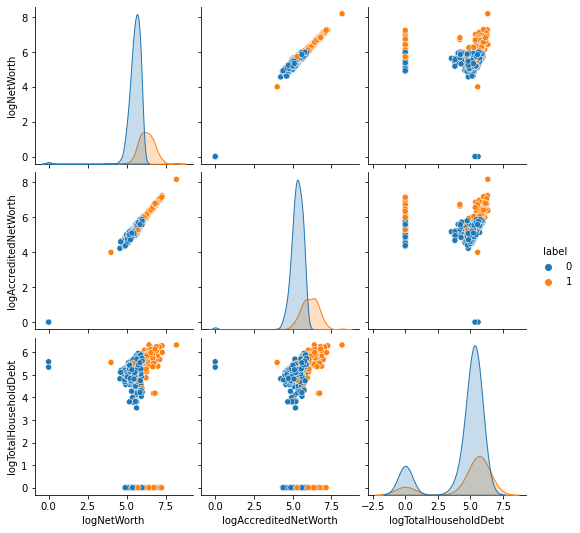

In [38]:
import seaborn as sns

sns.pairplot(df[["logNetWorth", "logAccreditedNetWorth", "logTotalHouseholdDebt", "label"]].sample(frac=0.05), hue='label', palette="tab10")

In [39]:
from fastai.tabular.all import (Categorify, CategoryBlock, FillMissing,
                                Normalize, TabDataLoader, TabularPandas,
                                tabular_config, tabular_learner)

procs = [FillMissing, Categorify, Normalize]

In [40]:
# train_ds.tabular_pandas["num_cars"]

In [41]:
from fastai.data.core import range_of
from fastai.tabular.all import RandomSplitter, TrainTestSplitter

splits = TrainTestSplitter(test_size=0.20, 
                           train_size=0.80, 
                           random_state=None, 
                           stratify=df["label"].values, 
                           shuffle=True)(range_of(df))

In [42]:
tabular_pandas = TabularPandas(
        df,
        procs=procs,
        cat_names=cat_names,
        cont_names=cont_names,
        y_names=y_names,
        y_block=y_block,
        splits=splits,
        device="cpu")

In [43]:
# from mobius.samplers import ImbalancedDatasetSampler

trn_dl = TabDataLoader(
    tabular_pandas.train,
    bs=32,
    shuffle=True,
    drop_last=True,)

val_dl = TabDataLoader(
    tabular_pandas.valid,
    bs=32,)

In [44]:
from fastai.data.core import DataLoaders

dls = DataLoaders(trn_dl, val_dl)

# print("Sample batch:")
# dls.one_batch()

In [48]:
# dls.one_batch()

In [49]:
import torch
from fastai.metrics import F1Score, Precision, Recall, accuracy

# load the tabular_pandas data through the tabular_learner
layers = [512, 128, 32]

# tabular learner configuration
config = tabular_config(ps=[0.05, 0.05, 0.05], embed_p=0.03, act_cls=torch.nn.Tanh())

# create tabular learner
#
learn = tabular_learner(
    dls,
    layers=layers,
    emb_szs=emb_szs,
    config=config,
    metrics=[accuracy,
             Precision(average='macro'),
             Recall(average='macro'),
             F1Score(average='macro')])

In [50]:
learn.fit_one_cycle(n_epoch=5)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.332215,0.286976,0.870464,0.830697,0.861447,0.843401,00:04
1,0.265307,0.268484,0.882407,0.894214,0.801062,0.832657,00:04
2,0.240754,0.242444,0.898943,0.886165,0.850423,0.865872,00:04
3,0.218455,0.250112,0.893891,0.887926,0.834641,0.856066,00:04
4,0.213988,0.256112,0.893431,0.902667,0.821470,0.850871,00:04


In [51]:
# learn.export("tabular_learn_wine.pkl")

In [52]:
from mobius.calibration import ModelWithTemperature

scaled_model = ModelWithTemperature(learn.model)
scaled_model.set_temperature(val_dl)
learn.model = scaled_model.model

Before temperature - NLL: 0.256, ECE: 0.020
Optimal temperature: 1.015
After temperature - NLL: 0.256, ECE: 0.021


In [53]:
# true species labels
y_true=learn.dls.valid.items["label"]

# model scores and species predictions
y_scores, *_ = learn.get_preds(dl=val_dl)
preds = np.argmax(y_scores, 1).numpy()

In [54]:
print("First 20 species labels and predictions")
list(zip(y_true, preds))[:10]

First 20 species labels and predictions


[(0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0)]

In [55]:
(y_true == preds).sum() / len(y_true)

0.8934313275149288

In [56]:
# TODO: update roc-it with MultiClassClassification...

# clf_metrics = BinaryClassification(
#     y_true=y_true, y_scores=y_scores)

# ths = clf_metrics.recall_curve(0.95)

# clf_metrics.plot_confusion_matrix(
#     ths=0.50,
#     normalize=None,
#     save_path=f'{hyperparams["artifact_dir"]}/cm.png')

# clf_metrics.plot_pr_curve(
#     save_path=f'{hyperparams["artifact_dir"]}/pr_curve.png')

# clf_metrics.plot_roc_curve(
#     save_path=f'{hyperparams["artifact_dir"]}/roc_curve.png')

## Siamese Net

To init a new `TabularSiameseDataset` object, we only need a `tabular_pandas` object from the fast.ai library.

In [57]:
from mobius.datasets import TabularSiameseDataset

# sds = TabularSiameseDataset(tabular_pandas)
train_ds = TabularSiameseDataset(tabular_pandas.train)
valid_ds = TabularSiameseDataset(tabular_pandas.valid)

In [58]:
train_ds.__getitem__(10)

((tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]),
  tensor([-0.6414,  1.9611,  2.2108, -0.0186,  2.8969,  2.9080, -0.2304, -0.0429,
          -0.0812, -0.0662, -0.0515, -0.1985,  0.0000, -0.0480,  0.0000, -0.0515,
          -0.0415, -0.0284,  2.0040,  2.3915,  0.4217,  0.8706, -0.0284, -0.0303,
          -0.5492, -0.3174, -0.0415, -0.0284, -0.0312,  1.2452,  3.5626, -0.4054,
          -0.3489, -0.0322, -1.3036, -1.5895, -0.1363, -0.1987,  0.2655, -0.5992,
           3.0284,  0.3986,  2.7213, -0.0790,  2.3267,  2.9607,  1.6428,  1.3361,
           1.7619, -0.5493, -0.6937, -0.4345, -0.8862, -0.8830, -0.0993, -0.2180,
          -0.2399, -0.1691, -0.2659, -0.3159, -0.0356, -0.1572, -0.0833, -0.0944,
          -0.1993, -0.2163, -0.1604, -0.2507, -0.2972, -0.0348, -0.1482, -0.0739,
          -0.0356, -0.6062, -0.6610, -0.4328, -0.0353, -0.5538, -0.6048, -0.4075,
          -0.0353, -0.5588, -0.6041, -0.4059, -0.4879, -0.5431, -0.5427, -0.1896,
          -0.4948, -0.1774, -

In [59]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=32, device='cpu', num_workers=0)

Siamese net encoder is the body of the Tabular net we just trained.

In [60]:
import copy

encoder = copy.copy(learn)
encoder.model.layers = learn.model.layers[:-1]
encoder_model = encoder.model

We create a new head that doubles the input shape to the last layer of the trained Tabular net, since the loss function will now compare 2 penguins. The size of the output shape is set by...???

In [61]:
from fastai.layers import LinBnDrop

head = LinBnDrop(n_in=layers[-1]*2,
    n_out=16,  # size of output space
    bn=True,
    act=None)

In [62]:
# TODO: add custom fast.ai callback
import time
import torch
import pandas as pd
from fastai.callback.core import Callback
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# TODO: save every TSNE model as pkl - interactive 3-d w/ tooltip to show point information (id, features, etc.)
class TSNECallback(Callback):
    def after_validate(self):
        plt.clf()
        t = int(time.time())
        train_encoded = list()
        for i in range(len(self.dls.valid_ds.tabular_pandas)):
            p, _, _ = self.dls.valid_ds.get_items(i, 0)

            # rehsape into mini-batch size 1
            p = p[0].reshape(1, -1), p[1].reshape(1, -1)

            # encode the household into output embedding space
            p_encode = siamese_learner.model.encode(p)
            train_encoded.append(p_encode)
            
        ids = self.dls.valid.get_idxs()
        y_train_labels = self.dls.valid.tabular_pandas["label"]
        train_encoded_df = pd.DataFrame(torch.stack(train_encoded).squeeze())
        # write encoded space to csv
        train_encoded_df.to_csv(f"tsne_{t}_{self.epoch}.csv")
        
        # limit the permutation of hyper-params of t-SNE
        tsne = TSNE(n_components=2, metric="euclidean", n_iter=500)
        encoded_train_tsne = tsne.fit_transform(train_encoded_df.values)
        np.save(f"tsne_{t}_{self.epoch}.npy", encoded_train_tsne)
        
        # TODO: add title...
        sns.scatterplot(x=encoded_train_tsne[:,0],
                        y=encoded_train_tsne[:,1],
                        hue=y_train_labels, 
#                         legend='full', 
                        palette="tab10").figure.savefig(f"snn_{t}_epoch_{self.epoch}.png")
        
        
# TODO: run knn on embedding space to show learned embedding is informative!!!

In [63]:
from mobius.models import TabularSiameseModel

model = TabularSiameseModel(encoder_model, head)

In [64]:
# TODO: run grid search over margin... how do we find and start with intelligent margins?
# ... instead of relying on brute force searching?

# def fit_siamese_learner(margin=0.10)

In [65]:
# TODO: reverse the pre-trained operation to learn a SNN and load the pre-trained weights into TabularLearner

In [66]:
from fastai.torch_basics import params
from mobius.losses import ContrastiveLoss

def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

def contrastive_loss_func(out, targ):
    return ContrastiveLoss(margin=1.0)(out, targ.long())

In [67]:
from fastai.learner import Learner

siamese_learner = Learner(dls,
    model,
    model_dir=".",
    loss_func=contrastive_loss_func,
    splitter=siamese_splitter,
    cbs=[TSNECallback])

In [68]:
# # %debug
# siamese_learner.unfreeze()
# siamese_learner.fit_one_cycle(n_epoch=20)

In [69]:
y_labels = siamese_learner.dls.valid.tabular_pandas["label"]
y_labels.to_csv("y_labels.csv")

epoch,train_loss,valid_loss,time
0,29.685274,19.522541,18:23


IndexError: index 1 is out of bounds for dimension 0 with size 1

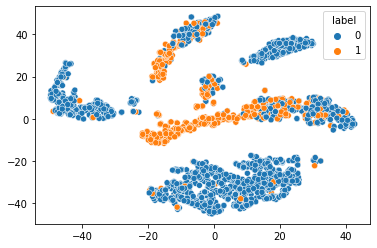

In [70]:
# siamese_learner.unfreeze()

# lr_min, _ = siamese_learner.lr_find()
siamese_learner.fit(n_epoch=10, lr=1e-4)

In [ ]:
# siamese_learner.unfreeze()

# lr_min, _ = siamese_learner.lr_find()
# siamese_learner.fit(n_epoch=3, lr=lr_min)

In [ ]:
# original_points = list()
# for i in range(len(valid_ds)):
#     p, _, _ = valid_ds.get_items(i=i, j=0)
#     original_points.append(pd.Series(np.concatenate([p[0].numpy(), p[1].numpy()])))

In [ ]:
t0 = pd.DataFrame(original_points)
# t0 = pd.concat([y_labels.reset_index(drop=True), t0], ignore_index=False, axis=1)
t0.head()

In [ ]:
t4 = pd.read_csv("tsne_1618741679_4.csv").drop("Unnamed: 0", axis=1)
# t4 = pd.concat([y_labels.reset_index(drop=True), t4], ignore_index=False, axis=1)
t4.head()

In [ ]:
from sklearn.model_selection import train_test_split

#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(t0, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 4)

# Fit the classifier to the data
knn.fit(X_train, y_train)

In [ ]:
#show first 5 model predictions on the test data
knn.predict(X_test)[0:5]

In [ ]:
#check accuracy of our model on the test data
knn.score(X_test, y_test)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

pr, re, fs, _ = precision_recall_fscore_support(y_test, knn.predict(X_test))
print(confusion_matrix(y_test, knn.predict(X_test)))
f"precision: {pr[1]}, recall: {re[1]}, fscore: {fs[1]}"

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

#create a new KNN model
knn_cv = KNeighborsClassifier(n_neighbors=3)

#train model with cv of 5 
cv_scores = cross_val_score(knn_cv, X_train, y_train, cv=5)

#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

In [ ]:
from sklearn.model_selection import GridSearchCV

#create new a knn model
knn2 = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

#fit model to data
knn_gscv.fit(X_train, y_train)

In [ ]:
#check top performing n_neighbors value
knn_gscv.best_params_

In [ ]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

In [ ]:
np.load("tsne_1618681529_0.npy")